In [118]:
%pip install --upgrade google-cloud-aiplatform
%pip install --upgrade langchain
%pip install --upgrade python-dotenv
%pip install --upgrade langchain-google-vertexai
%pip install --upgrade langchain-community
%pip install --upgrade langgraph

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
from google.cloud import aiplatform

aiplatform.init(    
    project='cyrus-testing-2023',
    location='us-central1',
)

In [8]:
from langchain_google_vertexai import HarmBlockThreshold, HarmCategory

safety_settings = {
    HarmCategory.HARM_CATEGORY_UNSPECIFIED: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

In [72]:
from langchain_google_vertexai import ChatVertexAI
parameters = {
    "model_name": "gemini-2.0-flash-001",
    "safety_settings":safety_settings,
    "temperature": 1.5,
    "max_output_tokens": 8192,
    "top_p": 0.95,
    "top_k": 5,
    }
model = ChatVertexAI(**parameters)

In [79]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
import base64
from mimetypes import guess_type

from pydantic import BaseModel

class Character(BaseModel):
    name: str
    age: int
    personality: str
    dialogue_style: str
    background_story: str
    gender: str
    interests: str
    description: str
    image_path: str


# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    mime_type, _ = guess_type(image_path)
    # Default to png
    if mime_type is None:
        mime_type = 'image/png'

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"


def describe_image(image_path:str) -> Character:
    template = """
You are a game journalist tasked with describing a game sprite image. You will be provided with an image of the sprite. Your task is to describe the sprite, including its name, personality, and role in the game.

If the image is unclear or does not appear to be a game sprite, respond with "The provided image is unclear or does not appear to be a game sprite. Please provide a clearer image or more information."

If the name, personality, and role cannot be derived from the image, create them based on the visual characteristics of the sprite.

Your description should be 300 words or less. 

Your description should be 300 words or less. Return a JSON with the following fields: `name`, `age`, `personality`, `dialogue_style`, `background_story`, `gender`, `interests`, and `description`.

Sprite Image: 
"""
    parser = JsonOutputParser(pydantic_object=Character)
    prompt_template =  HumanMessagePromptTemplate.from_template(
            template=[
                {"type": "text", "text": template},
                {
                    "type": "image_url",
                    "image_url": "{encoded_image_url}",
                },
            ],           
    )
    image_prompt = ChatPromptTemplate.from_messages([prompt_template])
    
    chain = image_prompt | model | parser
    encoded_image_url = local_image_to_data_url(image_path)
    character = chain.invoke(input={"encoded_image_url":encoded_image_url})
    character["image_path"] = image_path
    return character

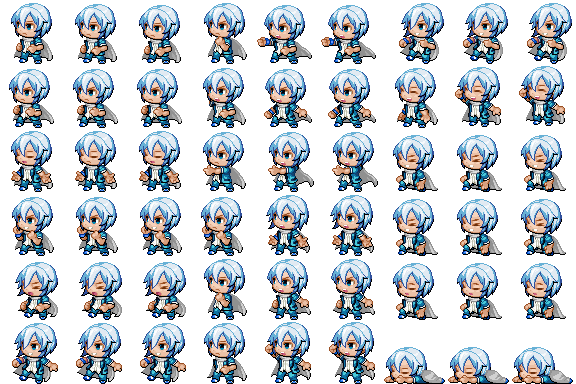

### Response:

{'name': 'Kyan', 'age': '16', 'personality': 'Confident and playful, with a bit of a mischievous streak. Tries to act cool, but sometimes his true, earnest nature shines through. He is determined to master his elemental abilities.', 'dialogue_style': 'Often uses slang and puns, but is surprisingly eloquent when the situation demands it. Sometimes winks when trying to trick people, but also sometimes does so naturally when speaking to close friends. He likes to tease people he likes', 'background_story': 'Kyan comes from a long line of ice elementalists, but his control over his abilities is still a bit shaky. He left home seeking to control them and become more than just the child from his heritage.', 'gender': 'Male', 'interests': 'Training, making friends, adventure, proving himself.', 'description': 'Kyan is a young sprite with striking light blue hair, and bright blue eyes. He wears a dark blue outfit with white trimming. A grey cloaklet rests on his shoulders. He has an expressive face, captured in various poses, ranging from winking and smirking to looking determined and focused. This character has an energetic air, as the multiple images of Kyan portray combat poses, and movements which signal that Kyan is ready for action.', 'image_path': '..\\img\\sv_actors\\k8s-learner.png'}

In [80]:
from IPython.display import display, Markdown, Image

image_path = "..\\img\\sv_actors\\k8s-learner.png"
response = describe_image(image_path)
# Load and display the image

display(Image(filename=image_path))

# Display the response as markdown
response_markdown = f"### Response:\n\n{response}"
display(Markdown(response_markdown))

In [84]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field
import os
import json

image_folder = "..\\img\\sv_actors"

story_prompt = """
Write a story based on the following information:

Topic: {topic}

Characters: 

{characters}

The story should adhere to the following guidelines:

1. Word Limit: The story should be 1500 words or less.
2. Engagement: The story should be engaging and interesting, capturing the reader's attention from the beginning.
3. Character Development: Describe the characters in detail, making them relatable and well-developed.  Explore their motivations, backgrounds, and relationships in between all characters.
4. Appropriateness: The story should be appropriate for all audiences, avoiding any explicit or offensive content.
5. Structure: The story should be well-structured with a clear beginning, rising action, climax, falling action, and resolution.
6. Conflict and Resolution:  A clear conflict should drive the narrative, and the resolution should be satisfying and logical.
7. Moral/Message: The story should have a clear moral or message that resonates with the reader.
8. Setting and Tone: Establish a vivid setting and maintain a consistent tone throughout the story.
9. Plot and Character Development: The plot should be compelling, and the characters should undergo meaningful development throughout the narrative.
10. Climax and Conclusion: The climax should be a pivotal moment in the story, and the conclusion should tie up loose ends and provide closure.
11. Theme and Purpose: The story should have a clear theme and purpose, adding depth and meaning to the narrative.
12. Narrative Voice and Style:  Maintain a consistent narrative voice and style that suits the story's tone and genre.
13. Point of View and Perspective: Choose a point of view (e.g., first-person, third-person limited, third-person omniscient) and maintain a consistent perspective throughout the story.

The story:
"""


class Images(BaseModel):
    image_paths: list[str]


class Story(BaseModel):
    content: str = Field(description="The story content.")


class OverallState(TypedDict):
    topic: str
    image_paths: list
    characters: Annotated[list[Character], operator.add]
    story: str


class ImageState(TypedDict):
    image_path: str


# This is the function we will use to generate the subjects of the jokes
def get_images(state: OverallState):
    image_files = [
        os.path.join(image_folder, f)
        for f in os.listdir(image_folder)
        if f.endswith(".png")
    ]
    return {"image_files": image_files}


# Here we generate a joke, given a subject
def generate_character(state: ImageState):
    image_path = state["image_path"]
    response = describe_image(image_path)
    json_path = image_path.replace(".png", ".json")
    with open(json_path, "w") as f:
        f.write(json.dumps(response, indent=4))
    return {"characters": [response]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_description(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_character", {"image_path": s}) for s in state["image_files"]]


def check_for_duplicates_edge(
    state: OverallState,
) -> Literal["generate_relationship_story", "found_duplicates"]:
    characters = state["characters"]
    seen = set()
    for character in characters:
        name = str(character["name"])
        if name in seen:
            return "found_duplicates"
        seen.add(name)
    return "generate_relationship_story"


def generate_relationship_story(state: OverallState):

    def print_character(character):
        return f"""

        Name: {character["name"]}
        Age: {character["age"]}
        Personality: {character["personality"]}
        Dialogue Style: {character["dialogue_style"]}
        Background Story: {character["background_story"]}
        Gender: {character["gender"]}
        Interests: {character["interests"]}
        Description: {character["description"]}
        
        """
    characters = state["characters"]
    character_str = [print_character(character) for character in characters]
    prompt = story_prompt.format(topic=state["topic"], characters=character_str)
    response = model.with_structured_output(Story).invoke(prompt)
    return {"story": response}


def check_for_duplicates(state: OverallState):
    return {}


def found_duplicates(state: OverallState):
    return {}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("get_images", get_images)
graph.add_node("generate_character", generate_character)
graph.add_node("check_for_duplicates", check_for_duplicates)
graph.add_node("generate_relationship_story", generate_relationship_story)
graph.add_node("found_duplicates", found_duplicates)

graph.add_edge(START, "get_images")
graph.add_conditional_edges(
    "get_images", continue_to_description, ["generate_character"]
)
graph.add_edge("generate_character", "check_for_duplicates")
graph.add_conditional_edges("check_for_duplicates", check_for_duplicates_edge)

graph.add_edge("generate_relationship_story", END)
graph.add_edge("found_duplicates", END)
app = graph.compile()

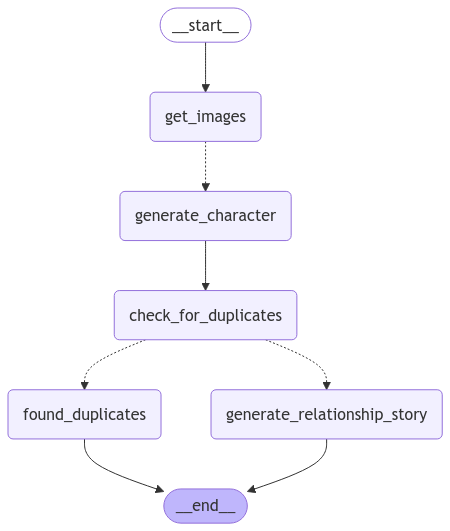

In [85]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [86]:
result = None
for s in app.stream({"topic": "Kubernetes Isekai (異世界)"}, { "max_concurrency": 2}):
    print(s)
    result = s

{'get_images': None}
{'generate_character': {'characters': [{'name': 'Lysandra', 'age': '19', 'personality': 'Lysandra is courageous and a bit of a goofball. She tries to appear serious, but her youthful energy and tendency to wink at inappropriate times often give her away. Despite her quirky behavior, she is deeply loyal and always puts the needs of others before her own.', 'dialogue_style': "Lysandra's dialogue is filled with slang and anachronisms for the setting. She is prone to puns and sarcastic remarks but is also genuinely encouraging. She sometimes struggles to articulate complex thoughts.", 'background_story': 'Lysandra is the youngest daughter of a long line of royal knights, forced into the family tradition to protect her kingdom, something that was not her desire.', 'gender': 'Female', 'interests': 'Weapon maintenance, bad jokes, supporting people that are loyal to her, training her abilities, and spending time with loved ones', 'description': 'Lysandra is a pixelated spr

In [87]:
from IPython.display import display, Markdown, Image

display(Markdown(result['generate_relationship_story']['story'].content))

The hum was the first sign. A low thrumming that resonated not in the ears, but in the very bones of Sir Reginald "Reggie" Strongforth. One moment, he was practicing swordplay in the Royal courtyard, the next, the world dissolved into a kaleidoscope of colors, textures shifting and reforming around him. When the chaos subsided, he found himself… somewhere else.

The courtyard was gone. In its place sprawled a landscape of impossible geometry, floating islands connected by shimmering threads of light, and monolithic structures that defied gravity. A low polygon sun cast long, jagged shadows across the terrain. Reggie, despite his initial terror, couldn't help but feel a thrill of adventure. This… this was an Isekai, just like in the stories!

"W-well, I'll be!" he stammered, adjusting his breastplate. "Looks like I've landed in another world!"

A voice, dripping with sarcasm, cut through the otherworldly silence. "No, Sherlock. You've just stumbled into a high-fidelity toaster oven." The speaker was a young woman in blue and white armor, leaning against a fractured obelisk. Lysandra, as her pixelated name tag identified her, winked. "Welcome to Kubernetes Konflux. Population: stressed developers and confused adventurers like yourself."

Before Reggie could properly process her slang-ridden greeting, a whirlwind of orange hair crashed into them. "Lysandra! Look what I found!" Roric, a street-smart warrior with battle scars and boundless energy, brandished a broken sword. "It's like… totally glitched out! Can you fix it?"

"Dude, seriously?" Lysandra sighed dramatically. "I'm not tech support. I'm a knight…sort of." She looked pointedly at Reggie. "Though, we could use the backup. Newbie, what's your deal?"

Reggie straightened his posture, attempting to project an air of competence despite the nervous stutter that threatened to overtake him. "Sir Reginald Strongforth, at your service! Knight of the Royal Guard… well, formerly of the Royal Guard, I suppose. I am… I am ready to aid you in any way I can!"

"Alright, Sir Reginald Formerly-of-the-Royal-Guard," Lysandra said, a grin spreading across her face. "Welcome to the party. We're currently trying to prevent a system-wide meltdown before it wipes out this whole reality."

Thus began Reggie's foray into the absurd world of Kubernetes Konflux. He soon learned that this Isekai wasn't governed by magic or dragons, but by the arcane laws of cloud computing and the whims of rogue algorithms. The islands represented different "pods," each housing fragments of reality, and the threads of light were the connections keeping them all running. A critical "deployment" had gone awry, corrupting the system and spawning monstrous bugs that threatened to devour everything.

The initial team quickly grew. They encountered Rona, a practical and headstrong warrior, always ready to protect her village, who added a fierce edge to the team. Rylan, an excitable adventurer whose infectious enthusiasm brought a bit of levity to stressful situations. Kaelen, a sarcastic young adventurer with a mysterious red scarf, with unexpected depths, Sir Gideon, a brave but insecure knight seeking validation. Anya Steelheart, a stern but loyal knight, known for her perfect defenses, Ren, a warrior learning to control the power of the elements. Lysander, a mysterious mage whose wisdom and strategic brilliance guided them through treacherous scenarios. Sister Agnes, a cleric on a spiritual quest whose knowledge of the lore became surprisingly useful. Elara, a temple maiden finding her way into a strange and magical land and Rory, a very small wizard apprentice who was a natural at debugging the matrix.

And then there were Elara the Enchantress, who gave them hints and insights into how to navigate the dangerous world, Elara Meadowlight, an alchemist in training that mixed potions to assist the heroes on their way. And there was also Esmeralda, last of a linage of Seers whose predictions were usually accurate, Kenji, an avenging warrior ready to battle. They soon added to the team Flora, a kind herbalist who helped them understand the local ecosystems of this magical realm. As well as Nanuq, a young explorer from the artic, and Willow Whimsy, a timid apprentice witch with a knack for understanding plants. The final recruit was Caelus, a young ice wizard, with a passion for fighting the good fight.

Reggie found his swordsmanship surprisingly effective against the corrupted data packets that materialized as grotesque creatures. Lysandra, despite her sardonic attitude, was a brilliant strategist, able to reroute the chaotic connections with astonishing speed. Roric’s impetuosity often led them into trouble, but his raw power was undeniable.

As they delved deeper into the heart of the system, they discovered the source of the corruption: a single, rogue line of code, an accidental typo that had spiraled out of control. The line was protected by a firewall of monstrous proportions, guarded by an avatar of the corrupted deployment itself: a towering golem of twisted logic and broken algorithms.

The battle was fierce. Reggie parried attacks with his pixelated sword, Lysandra wove defensive matrices, Roric smashed through corrupted nodes, with all the help of the recruits. As Gideon fought at the front lines and the Mages blasted from afar.

Finally, after a grueling back and forth, Lysandra saw an opening. "Reggie! Now!" she shouted.

With a surge of adrenaline, Reggie channeled his inner knight. He recalled all the tales of brave warriors he had cherished since childhood. He focused, ignoring the swirling chaos, the looming golem, and the ever-present hum of the corrupted system. He leaped forward, his sword a blur of steel.

The sword struck true. Not at the golem itself, but at the rogue line of code at its core. A blinding flash of light engulfed the arena, and the hum ceased.

Silence descended, broken only by the ragged breaths of the weary heroes.

The golem crumbled into dust. The corruptions began to recede, the connections flickering back into stability.

"We did it," Lysandra breathed, a rare smile gracing her lips.

The world of Kubernetes Konflux slowly began to stabilize, restoring to its slightly off-kilter normalcy.

As Reggie stood there, victorious but exhausted, he realized something profound. He wasn't just a knight anymore. He was a debugger, a troubleshooter, a hero in a world built on code and fueled by caffeine.

Before long Reggie said farewell to his companions and started missing his old home. "Thank you all" Said Reggie, who was suddenly disrupted, and a blinding light took over the arena.

The hum was back, the world dissolved in front of him once more. The colors swirled, the textures melted.

Reggie found himself once again in the courtyard, sword in hand, the midday sun warm on his face.

"Did it all happen? Or was it just a dream?" Thought Reggie. There wasn't an answer.

Reggie was no longer nervous about any potential quest in front of him and went back to practicing his skills, but this time in an orderly fashion.

From that moment on, Reggie trained to prepare for anything that came in his way, but he never got transported to the same Isekai again, however, all his future battles in his known world, had something from his quest against Kubernetes Konflux and he won.

The moral of the story is: Adventure can change and develop your life to reach new heights. Also, to never understimate an engineer in training, and all sorts of unexpected alliances will rise with the test of time. Never stop dreaming and keep chasing that new horizon to make all your achievements come true. Also, to keep believing and learning no matter the difficulties in life's many challenges.



In [88]:
file_path = os.path.join(image_folder, "story.md")
with open(file_path, "w") as file:
    file.write(result['generate_relationship_story']['story'].content)

In [92]:
chinese_story = model.invoke("Translate the story into Traditional Chinese. \n\n" + result['generate_relationship_story']['story'].content + "\n\nThe translated story is:")

In [93]:
from IPython.display import display, Markdown

display(Markdown(chinese_story.content))

以下是用繁體中文翻譯的故事：

那嗡嗡聲是第一個徵兆。一種低沉的轟鳴，不是在耳中，而是在雷金納德"雷吉"·史壯福斯爵士的骨頭裡產生共鳴。前一刻，他還在皇家庭院練習劍術，下一刻，世界就溶解成一個萬花筒，色彩和紋理在他周圍移動和重組。當混亂平息時，他發現自己... 在另一個地方。

庭院消失了。取而代之的是一片不可能的幾何景觀，漂浮的島嶼由閃爍的光線連接，以及無視重力的巨石結構。一顆低解析度的太陽在地形上投下長而鋸齒狀的陰影。雷吉儘管最初感到恐懼，卻忍不住感到一陣冒險的興奮。這...這是一個異世界，就像故事裡寫的那樣！

「哇… 天啊！」他結結巴巴地說，整理了一下胸甲。「看來我已經降臨到另一個世界了！」

一個充滿諷刺意味的聲音劃破了這異世界的寂靜。「不，夏洛克。你只是偶然走進了一個高保真烤麵包機。」說話者是一位穿著藍白色盔甲的年輕女子，靠在一根破碎的方尖碑上。莉珊卓，就像她的像素化姓名標籤顯示的那樣，眨了眨眼。「歡迎來到Kubernetes Konflux。人口：壓力重重的開發人員和你這樣困惑的冒險家。」

在雷吉能夠充分理解她那充滿俚語的問候之前，一股橙色的頭髮旋風撞向了他們。「莉珊卓！看看我找到了什麼！」羅里克，一個街頭智慧的戰士，身上滿是戰鬥傷疤和無盡的精力，他揮舞著一把斷劍。「這就像…完全出錯了！你能修好它嗎？」

「老兄，認真的？」莉珊卓誇張地嘆了口氣。「我又不是技術支援。我是一個騎士…算是吧。」她指了指雷吉。「不過，我們倒是可以用上備援人力。菜鳥，你是什麼來頭？」

雷吉挺直腰桿，試圖表現出一副有能力的外表，儘管他緊張的口吃可能會吞噬他。「雷金納德·史壯福斯爵士，為您效勞！皇家衛隊的騎士… 嗯，我想，以前是皇家衛隊。我…我已準備好盡我所能來幫助你們！」

「好吧，雷金納德·史壯福斯前皇家衛隊騎士先生，」莉珊卓說，臉上露出了笑容。「歡迎參加派對。我們目前正在努力阻止一個全系統崩潰，免得它摧毀整個現實。」

於是，雷吉開始了他的異世界Kubernetes Konflux的荒謬冒險。他很快了解到，這個異世界不是由魔法或龍所支配，而是由雲端運算的神秘法則和流氓演算法的異想天開所統治的。這些島嶼代表不同的 "Pods"，每個 Pod 都包含現實的片段，而光線則是維持它們運轉的連接。一個關鍵的 "部署" 出錯了，導致系統崩潰，並產生了可怕的錯誤，威脅要吞噬一切。

最初的團隊很快壯大起來。他們遇到了蘿娜，一個務實而倔強的戰士，總是準備保護她的村莊，為團隊增添了一絲堅韌。還有萊蘭，一個令人興奮的冒險家，他那具有感染力的熱情為緊張的局勢帶來了一絲輕鬆。 凱倫，一個帶著神秘紅色圍巾，有點尖酸刻薄的年輕冒險家，身上隱藏著意想不到的深度； 吉迪恩爵士，一個勇敢但不安全的騎士，渴望得到認可； 安雅·鋼鐵之心，一個嚴厲但忠誠的騎士，以她完美的防禦而聞名； 任，一個正在學習控制元素力量的戰士； 萊桑德，一位神秘的法師，他的智慧和戰略天才引導他們穿越了危險的境地； 艾格尼絲修女，一位在精神上探索，她對傳說的了解變得出奇地有用的神職人員； 伊萊亞，一位正在尋找進入一個奇怪而神奇的土地的寺廟少女； 還有羅里，一位非常小的巫師學徒，他天生就擅長偵錯矩陣。

然後還有魅惑師伊萊亞，她給他們提示和見解，告訴他們如何在這個危險的世界中航行； 草地之光伊萊亞，一個正在接受培訓的煉金術士，她混合魔藥來幫助英雄們上路。還有愛斯梅達拉，最後一位先知血統，她們的預言通常是準確的； 健二，一個隨時準備戰鬥的復仇戰士。他們很快就將善良的草藥師芙蘿拉也加入到團隊中，她幫助他們了解這個魔法王國的當地生態系統。以及來自北極的年輕探險家楠努克，還有有理解植物天賦的靦腆的女巫學徒威柳·奇想。最後一位新兵是充滿熱情與善良而戰的年輕冰法師卡耶勒斯。

雷吉發現他的劍術出奇地有效，能夠對抗那些實體化的、怪誕的受損數據包。莉珊卓儘管態度有些諷刺，卻是一位出色的策略家，能夠以驚人的速度重新佈線混亂的連接。羅里克的衝動常常使他們陷入麻煩，但他原始的力量是不可否認的。

當他們深入系統的核心時，他們發現了錯誤的根源：一行單一的、流氓程式碼，一個意外的拼寫錯誤，卻失去了控制。這行程式碼受到一個巨大防火牆的保護，由一個被損壞的部署本身的化身所守護：一個由扭曲的邏輯和損壞的演算法組成的巨大魔像。

戰鬥非常激烈。雷吉用他的像素劍擋開攻擊，莉珊卓編織防禦矩陣，羅里克則摧毀受損的節點，一切都借助了所有新兵的幫助。而吉迪恩在前線作戰，法師們則從遠處轟擊。

最後，經過一番艱苦的拉鋸戰，莉珊卓看到了機會。「雷吉！現在！」她喊道。

隨著腎上腺素的激增，雷吉調動了他內心的騎士精神。他回想起自童年以來就珍視的勇敢戰士的故事。他集中精神，忽略了旋轉的混亂、迫在眉睫的魔像，以及那永恆的受損系統嗡嗡聲。他向前躍起，他的劍成了一道鋼鐵的模糊光芒。

劍刺中了要害。不是在魔像本身，而是刺中了它核心的那行流氓程式碼。一道耀眼的光芒吞噬了競技場，嗡嗡聲停止了。

寂靜降臨，唯一打破寂靜的是疲憊英雄們的喘息聲。

魔像化為灰燼。損壞開始消退，連接閃爍著恢復穩定。

「我們做到了，」莉珊卓呼吸著說，罕見的笑容爬上了她的嘴唇。

Kubernetes Konflux 的世界慢慢開始穩定下來，恢復到它那有點不平衡的常態。

雷吉站在那裡，雖然筋疲力盡，但卻勝利了，他意識到了一些深刻的事情。他不再只是一個騎士。他是一個除錯器，一個疑難排解員，一個建立在程式碼之上，由咖啡因驅動的世界中的英雄。

不久，雷吉就向他的夥伴告別，並開始想念他的老家。「謝謝你們所有人，」雷吉說道，但他突然被打斷，一道耀眼的光芒接管了競技場。

那嗡嗡聲又回來了，世界再次在他面前溶解。色彩旋轉，紋理融化。

雷吉發現自己再次回到了庭院，手裡拿著劍，正午的陽光溫暖地照在他的臉上。

「這一切都發生了嗎？還是只是一場夢？」雷吉心想。沒有答案。

雷吉不再對眼前的任何潛在任務感到緊張，並開始練習他的技能，但這次是有條不紊地進行。

從那一刻起，雷吉努力訓練，為他前進道路上可能遇到的任何事情做好準備，但他再也沒有被傳送到同一個異世界。然而，他在已知世界中進行的所有未來戰鬥，都帶有一些與對抗 Kubernetes Konflux 的任務相關的元素，因此他成功了。

故事的寓意是：冒險可以改變和發展你的生活，達到新的高度。另外，永遠不要低估一個正在接受培訓的工程師，而且隨著時間的考驗，各種意想不到的聯盟將會出現。永遠不要停止夢想，並不斷追逐那新的視野，以實現你的所有成就。同時，無論生活中遇到多少挑戰，都要保持信念並繼續學習。
